모듈 임포트 및 실험 변수 설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

Mounted at /content/drive
cuda


In [2]:
import random
random_seed = 0
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

In [4]:
BATCH_SIZE = 64
LR = 1e-3
EPOCH = 100
criterion = nn.CrossEntropyLoss()

데이터셋 준비

In [5]:
TARGET_IMG_SIZE = 224
CIFAR10_TRAIN_MEAN = (0.4914, 0.4822, 0.4465) # 원본 CIFAR-10 통계치
CIFAR10_TRAIN_STD = (0.2470, 0.2435, 0.2616) # 원본 CIFAR-10 통계치

# 기본 transform (업샘플링 + Tensor 변환 + 정규화)
transform_upsampled = transforms.Compose([
    transforms.Resize((TARGET_IMG_SIZE, TARGET_IMG_SIZE), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_TRAIN_MEAN, CIFAR10_TRAIN_STD)
])

# 기본 학습 데이터셋 (Augmentation 없음)
train_DS = datasets.CIFAR10(
    root = '/content/drive/MyDrive/Colab Notebooks/data',
    train=True,
    download=True,
    transform=transform_upsampled
)

# 기본 테스트 데이터셋 (Augmentation 없음)
test_DS = datasets.CIFAR10(
    root = '/content/drive/MyDrive/Colab Notebooks/data',
    train=False,
    download=True,
    transform=transform_upsampled
)

In [6]:
g = torch.Generator()
g.manual_seed(random_seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# 기본 학습 데이터로더 (Augmentation 미적용)
train_DL = torch.utils.data.DataLoader(
    train_DS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    generator=g,
    worker_init_fn=seed_worker,
    pin_memory=True
)

# 기본 테스트 데이터로더 (당연히 Augmentation 미적용)
test_DL = torch.utils.data.DataLoader(
    test_DS,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    generator=g,
    worker_init_fn=seed_worker,
    pin_memory=True
)

In [ ]:
# Augmentation용 transform (업샘플링 + Augmentation + Tensor 변환 + 정규화)
transform_train_augmented_upsampled = transforms.Compose([
    transforms.Resize((TARGET_IMG_SIZE, TARGET_IMG_SIZE), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(p=0.5), # 50% 확률로 좌우 반전
    transforms.RandomCrop(TARGET_IMG_SIZE, padding=int(TARGET_IMG_SIZE * 0.1), padding_mode='reflect'), # 10% 패딩 후 랜덤 크롭
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_TRAIN_MEAN, CIFAR10_TRAIN_STD),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random')
])

# 위는 맨 처음에 내가 만든 Augmentation용 transform 코드



# 아래는 2번째 실험방식 (실시간 증강을 그대로 적용하되, 일정확률로 원본 이미지 그대로를 학습하는 경우도 추가하는 방식)


# # 1. 조건부로 적용할 증강 기법들을 정의합니다.
# conditional_augmentations = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5), # 이 블록이 적용될 때, 내부적으로 50% 확률로 반전
#     transforms.RandomCrop(TARGET_IMG_SIZE, padding=int(TARGET_IMG_SIZE * 0.1), padding_mode='reflect')
# ])

# # 2. 새로운 학습용 transform 파이프라인 정의
# #    예: 50% 확률로 conditional_augmentations를 적용하고, 50% 확률로는 적용하지 않음 (Resize만 된 상태)

# transform_train_augmented_upsampled = transforms.Compose([
#     # 항상 적용되는 초기 Resize
#     transforms.Resize((TARGET_IMG_SIZE, TARGET_IMG_SIZE), interpolation=transforms.InterpolationMode.BILINEAR),
#     # conditional_augmentations 블록 전체를 prob_apply_conditional_augs 확률로 적용
#     transforms.RandomApply(
#         # RandomApply는 nn.Module로 구성된 리스트를 받는 것이 일반적이지만,
#         # transforms 객체들의 리스트를 직접 사용할 수도 있습니다.
#         # 여기서는 Compose 객체 하나를 리스트에 넣어 전달합니다.
#         [conditional_augmentations],
#         p=0.2
#     ),
#     # 항상 적용되는 최종 변환
#     transforms.ToTensor(),
#     transforms.Normalize(CIFAR10_TRAIN_MEAN, CIFAR10_TRAIN_STD)
# ])


# --------------------------------------------------------2번째 실험방식 끝--------------------------------------------------

# Augmentation용 학습 데이터셋 (Augmentation 적용)
train_DS_augmented = datasets.CIFAR10(
    root = '/content/drive/MyDrive/Colab Notebooks/data', # 데이터 저장 경로
    train=True,
    download=True,
    transform=transform_train_augmented_upsampled # Augmentation용 transform 사용
)

# Augmentation용 학습 데이터로더 (Augmentation 적용)
train_DL_augmented = torch.utils.data.DataLoader(
    train_DS_augmented,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    generator=g,
    worker_init_fn=seed_worker,
    pin_memory=True
)

In [7]:
print(f"Number of training samples: {len(train_DS)}")
print(f"Number of test samples: {len(test_DS)}")
print(f"Shape of one training sample: {train_DS[0][0].shape}")
print(f"Data type of one training sample: {train_DS[0][0].dtype}")
print(f"Label of one training sample: {train_DS[0][1]}")

Number of training samples: 50000
Number of test samples: 10000
Shape of one training sample: torch.Size([3, 224, 224])
Data type of one training sample: torch.float32
Label of one training sample: 6


AlexNet

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),  # 첫번째 Conv
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),           # 두번째 Conv
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),          # 세번째 Conv
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),          # 네번째 Conv
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),          # 다섯번째 Conv
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))                 # Adaptive Pooling
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),                           # Fully Connected 1
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),                                  # Fully Connected 2
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),                           # 출력층
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Train & Test Function

In [8]:
def Train(model, train_DL, criterion):
    optimizer = optim.Adam(model.parameters(), lr=LR)

    loss_history=[]
    acc_history=[]

    NoT = len(train_DL.dataset)

    model.train()

    for ep in range(EPOCH):
        rloss = 0
        rcorrect = 0

        for x_batch, y_batch in train_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            y_hat = model(x_batch)
            loss = criterion(y_hat, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_b = loss.item() * x_batch.shape[0]
            rloss += loss_b
            pred = y_hat.argmax(dim=1)
            corrects_b = torch.sum(pred == y_batch).item()
            rcorrect += corrects_b

        loss_e = rloss/NoT
        accuracy_e = rcorrect/NoT * 100
        loss_history += [loss_e]
        acc_history += [accuracy_e]
        print(f"Epoch: {ep+1}, train loss: {round(loss_e,3)}, train accuracy: {round(accuracy_e,1)} %")
        print("-"*20)

    return loss_history, acc_history

In [9]:
def Test(model,test_DL):
    model.eval()
    with torch.no_grad():
        rcorrect = 0
        for x_batch, y_batch in test_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            y_hat = model(x_batch)
            pred = y_hat.argmax(dim=1)
            corrects_b = torch.sum(pred == y_batch).item()
            rcorrect += corrects_b
        accuracy_e = rcorrect/len(test_DL.dataset)*100
    print(f"Test accuracy: {rcorrect}/{len(test_DL.dataset)} ({round(accuracy_e,1)} %)")
    return round(accuracy_e,1)

**실험 1**: Data Augmentation 성능 확인 (in AlexNet)

In [ ]:
model_no_aug=AlexNet().to(DEVICE)
print(model_no_aug)
x_batch, _ = next(iter(train_DL))
print(model_no_aug(x_batch.to(DEVICE)).shape)

print("="*30)
print(" Data Augmentation 적용하지 않은 상태로 AlexNet 학습")
print("="*30)

loss_history_no_aug, acc_history_no_aug = Train(model_no_aug, train_DL, criterion)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
print("="*30)
print("Data Augmentation 적용하지 않은 AlexNet 테스트")
print("="*30)
# Test 함수로 평가
test_accuracy_no_aug = Test(model_no_aug, test_DL)

Data Augmentation 적용하지 않은 AlexNet 테스트
Test accuracy: 6940/10000 (69.4 %)


In [ ]:
model_aug=AlexNet().to(DEVICE)
print(model_aug)
x_batch, _ = next(iter(train_DL_augmented))
print(model_aug(x_batch.to(DEVICE)).shape)

print("="*30)
print("실험 1: Data Augmentation 적용한 상태로 AlexNet 학습")
print("="*30)

loss_history_aug, acc_history_aug = Train(model_aug, train_DL_augmented, criterion)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
print("="*30)
print("Data Augmentation 적용한 AlexNet 테스트")
print("="*30)
# Test 함수로 평가
test_accuracy_aug = Test(model_aug, test_DL)

Data Augmentation 적용한 AlexNet 테스트
Test accuracy: 7711/10000 (77.1 %)


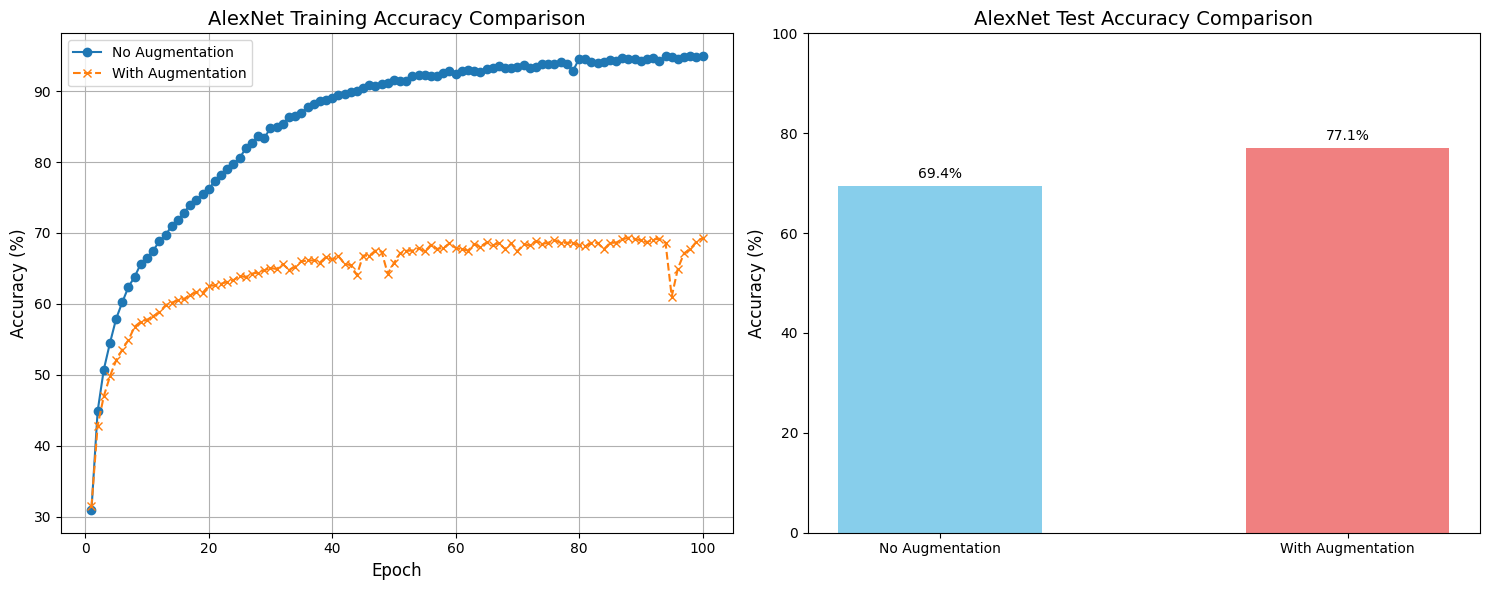

In [ ]:
# 에폭 범위 (X축으로 사용)
epochs_range = range(1, EPOCH + 1)

# 전체 그림(figure)의 크기를 설정합니다. (플롯 2개용으로 너비 조정)
plt.figure(figsize=(15, 6)) # 이전보다 너비를 약간 줄여도 괜찮습니다.

# 1. 학습 정확도(Training Accuracy) 비교
plt.subplot(1, 2, 1) # 1행 2열의 첫 번째 플롯
plt.plot(epochs_range, acc_history_no_aug, marker='o', linestyle='-', label='No Augmentation')
plt.plot(epochs_range, acc_history_aug, marker='x', linestyle='--', label='With Augmentation')
plt.title('AlexNet Training Accuracy Comparison', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# 2. 최종 테스트 정확도(Final Test Accuracy) 비교 (막대 그래프)
plt.subplot(1, 2, 2) # 1행 2열의 두 번째 플롯
labels = ['No Augmentation', 'With Augmentation']
test_accuracies = [test_accuracy_no_aug, test_accuracy_aug]

bars = plt.bar(labels, test_accuracies, color=['skyblue', 'lightcoral'], width=0.5)
plt.title('AlexNet Test Accuracy Comparison', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 100) # Y축 범위를 0에서 100으로 설정 (정확도는 백분율)

# 각 막대 위에 정확도 값을 표시합니다.
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1.0, f'{yval:.1f}%', ha='center', va='bottom', fontsize=10)

# 플롯들이 겹치지 않도록 레이아웃을 조정합니다.
plt.tight_layout()
# 플롯을 화면에 표시합니다.
plt.show()

**실험 2:** 3x3 Convolution 3번 vs 7x7 Convolution 1번 (in VGG16)    

In [ ]:
class VGG16_3x3(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16_3x3, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 224 -> 112

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 112 -> 56

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 56 -> 28

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 28 -> 14

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 14 -> 7
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), # Block 5의 마지막 Conv2d 출력 채널은 512
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
class VGG16_7x7(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16_7x7, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 224 -> 112

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 112 -> 56

            # Block 3
            nn.Conv2d(128, 256, kernel_size=7, padding=3), # 원본 VGG 16과 다르게, 3x3 conv 3번 -> 7x7 conv 1번으로 변경
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 56 -> 28

            # Block 4
            nn.Conv2d(256, 512, kernel_size=7, padding=3),  # 원본 VGG 16과 다르게, 3x3 conv 3번 -> 7x7 conv 1번으로 변경
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 28 -> 14

            # Block 5
            nn.Conv2d(512, 512, kernel_size=7, padding=3),  # 원본 VGG 16과 다르게, 3x3 conv 3번 -> 7x7 conv 1번으로 변경
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 7 -> 7
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), # Block 5의 마지막 Conv2d 출력 채널은 512
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
import time

print("="*30)
print("표준 VGG16 모델 학습 (3x3 Convolution만 이용)")
print("="*30)

model_vgg16_3x3 = VGG16_3x3().to(DEVICE) # 이전에 정의한 표준 VGG16 클래스
print(model_vgg16_3x3)

# 1. 파라미터 수 계산
total_params_3x3 = sum(p.numel() for p in model_vgg16_3x3.parameters() if p.requires_grad)
print(f"\n표준 VGG16 파라미터 수: {total_params_3x3:,}")

# 2. 학습 연산 시간 측정
print(f"\n\n학습 시작")
start_time_3x3 = time.time()
loss_history_3x3, acc_history_3x3 = Train(model_vgg16_3x3, train_DL, criterion)
end_time_3x3 = time.time()
training_time_3x3 = end_time_3x3 - start_time_3x3
print(f"\nVGG16_3x3 총 학습 시간: {training_time_3x3:.2f} 초")

# 3. 분류 성능 평가
print("\nVGG16_3x3 테스트")
test_accuracy_3x3 = Test(model_vgg16_3x3, test_DL)


표준 VGG16 모델 학습 (3x3 Convolution만 이용)
VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_

In [ ]:
print("="*30)
print("7*7 Convolution으로 Custom한 VGG16 모델 학습 (3,4,5번째 블록만 변경)")
print("="*30)

model_vgg16_7x7 = VGG16_7x7().to(DEVICE) # 이전에 정의한 표준 VGG16 클래스
print(model_vgg16_7x7)

# 1. 파라미터 수 계산
total_params_7x7 = sum(p.numel() for p in model_vgg16_7x7.parameters() if p.requires_grad)
print(f"\n표준 VGG16 파라미터 수: {total_params_7x7:,}")

# 2. 학습 연산 시간 측정
print(f"\n\n학습 시작")
start_time_7x7 = time.time()
loss_history_7x7, acc_history_7x7 = Train(model_vgg16_7x7, train_DL, criterion)
end_time_7x7 = time.time()
training_time_7x7 = end_time_7x7 - start_time_7x7
print(f"\nVGG16_7x7 총 학습 시간: {training_time_7x7:.2f} 초")

# 3. 분류 성능 평가
print("\nVGG16_7x7 테스트")
test_accuracy_7x7 = Test(model_vgg16_7x7, test_DL)

7*7 Convolution으로 Custom한 VGG16 모델 학습 (3,4,5번째 블록만 변경)
VGG16_7x7(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(256, 512, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_

KeyboardInterrupt: 

In [ ]:
# 플롯 생성
epochs_range = range(1, EPOCH + 1)
model_labels = ['VGG16 (3x3 Conv)', 'VGG16 (7x7 Conv Customization)']

plt.figure(figsize=(18, 12)) # 4개의 플롯을 위한 크기 조정

# 1. 파라미터 수 비교
plt.subplot(2, 2, 1)
params_values = [total_params_3x3, total_params_7x7]
bars_params = plt.bar(model_labels, params_values, color=['skyblue', 'lightcoral'], width=0.5)
plt.title('모델 파라미터 수 비교', fontsize=14)
plt.ylabel('파라미터 수', fontsize=12)
plt.xticks(rotation=0, ha='center') # 레이블이 잘 보이도록 설정
# 막대 위에 값 표시
for bar in bars_params:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + max(params_values)*0.01, f'{int(yval):,}', ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--')

# 2. 학습 시간 비교
plt.subplot(2, 2, 2)
time_values = [training_time_3x3, training_time_7x7]
bars_time = plt.bar(model_labels, time_values, color=['skyblue', 'lightcoral'], width=0.5)
plt.title('Train Time Comparison', fontsize=14)
plt.ylabel('시간 (sec)', fontsize=12)
plt.xticks(rotation=0, ha='center') # 레이블이 잘 보이도록 설정
# 막대 위에 값 표시
for bar in bars_time:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + max(time_values)*0.01, f'{yval:.2f}s', ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--')

# 3. 에폭별 학습 정확도 비교
plt.subplot(2, 2, 3)
plt.plot(epochs_range, acc_history_3x3, marker='o', linestyle='-', label='VGG16 (3x3 Conv)')
plt.plot(epochs_range, acc_history_7x7, marker='x', linestyle='--', label='VGG16 (7x7 Conv Customization)')
plt.title('Train Accuracy Comparison', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Train Accuracy (%)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# 4. 최종 테스트 정확도 비교
plt.subplot(2, 2, 4)
test_accuracies_values = [test_accuracy_3x3, test_accuracy_7x7]
bars_test_acc = plt.bar(model_labels, test_accuracies_values, color=['skyblue', 'lightcoral'], width=0.5)
plt.title('Test Accuracy Comparison', fontsize=14)
plt.ylabel('정확도 (%)', fontsize=12)
plt.ylim(0, 100) # Y축 범위: 0에서 100 (정확도)
plt.xticks(rotation=0, ha='center') # 레이블이 잘 보이도록 설정
# 막대 위에 값 표시
for bar in bars_test_acc:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1.0, f'{yval:.1f}%', ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--')

# 플롯들이 겹치지 않도록 레이아웃 조정
plt.tight_layout()
plt.show()

**실험3:** GoogLeNet Inception Module의 1x1 conv에서 차원 축소는 왜 중요한가?

In [10]:
from typing import Optional, Tuple, Union, Any, List

class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.BatchNorm2d(ch1x1),
            nn.ReLU(inplace=True)
        )

        # 1x1 conv -> 3x3 conv branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.BatchNorm2d(ch3x3red),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ch3x3),
            nn.ReLU(inplace=True)
        )

        # 1x1 conv -> 5x5 conv branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.BatchNorm2d(ch5x5red),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2), # 5x5 conv, padding=2
            nn.BatchNorm2d(ch5x5),
            nn.ReLU(inplace=True)
        )

        # 3x3 maxpool -> 1x1 conv branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=5, stride=3) # 원본 논문 그림 참조 (output 4x4xChannels)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        # 논문에서는 이 conv 출력을 4x4x128로 기술
        self.fc1 = nn.Linear(128 * 4 * 4, 1024) # 4*4*128 = 2048. torchvision은 2048 사용.
                                               # 논문 그림에는 4x4x128을 flatten하고 FC로.
                                               # torchvision 구현은 AdaptiveAvgPool2d((1,1)) 쓰고 128을 fc1에 넣음.
                                               # 여기서는 논문 그림의 크기를 최대한 따름.
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(p=0.7) # 논문은 0.7, torchvision은 0.2

    def forward(self, x):
        # N x C x H x W
        x = self.avgpool(x)
        # N x C x 4 x 4 (for 14x14 input to aux head)
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)
        # N x (128*4*4)
        x = F.relu(self.fc1(x), inplace=True)
        x = self.dropout(x)
        x = self.fc2(x)
        # N x num_classes
        return x


class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10, aux_logits=False, dropout=0.2, dropout_aux=0.7):
        super(GoogLeNet, self).__init__()
        self.aux_logits = aux_logits

        # Stem: Conv -> Pool -> LRN -> Conv_reduce -> Conv -> LRN -> Pool
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        ) # 224x224 -> 112x112
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True) # 112x112 -> 56x56
        self.lrn1 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)

        self.conv2_reduce = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True)
        )
        self.lrn2 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True) # 56x56 -> 28x28

        # Inception modules
        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)  # out: 256
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64) # out: 480
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True) # 28x28 -> 14x14

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)   # out: 512
        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes) # 4a output
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)  # out: 512
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)  # out: 512
        if self.aux_logits:
            self.aux2 = InceptionAux(528, num_classes) # 4d output (다음 inception4d의 out_channels=528)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)  # out: 528
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128) # out: 832
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128) # out: 832
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128) # out: 1024

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Global Average Pooling
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[torch.Tensor]]:
        # N x 3 x 224 x 224
        x = self.conv1(x) # -> N x 64 x 112 x 112
        x = self.maxpool1(x) # -> N x 64 x 56 x 56
        x = self.lrn1(x)
        x = self.conv2_reduce(x) # -> N x 64 x 56 x 56
        x = self.conv2(x) # -> N x 192 x 56 x 56
        x = self.lrn2(x)
        x = self.maxpool2(x) # -> N x 192 x 28 x 28

        x = self.inception3a(x) # -> N x 256 x 28 x 28
        x = self.inception3b(x) # -> N x 480 x 28 x 28
        x = self.maxpool3(x) # -> N x 480 x 14 x 14

        x = self.inception4a(x) # -> N x 512 x 14 x 14
        aux1: Optional[torch.Tensor] = None
        if self.aux_logits and self.training: # Training때만 적용
            aux1 = self.aux1(x)

        x = self.inception4b(x) # -> N x 512 x 14 x 14
        x = self.inception4c(x) # -> N x 512 x 14 x 14
        x = self.inception4d(x) # -> N x 528 x 14 x 14
        aux2: Optional[torch.Tensor] = None
        if self.aux_logits and self.training: # Training때만 적용
            aux2 = self.aux2(x) # inception4d의 출력을 aux2에 전달

        x = self.inception4e(x) # -> N x 832 x 14 x 14
        x = self.maxpool4(x) # -> N x 832 x 7 x 7

        x = self.inception5a(x) # -> N x 832 x 7 x 7
        x = self.inception5b(x) # -> N x 1024 x 7 x 7

        x = self.avgpool(x) # -> N x 1024 x 1 x 1
        x = torch.flatten(x, 1) # -> N x 1024
        x = self.dropout(x)
        main_output = self.fc(x) # -> N x num_classes

        if self.aux_logits and self.training: # Training때만 적용
            return main_output, aux1, aux2
        return main_output




In [11]:
# --- 새로운 Inception 모듈 (1x1 차원 축소 제거) ---
class Inception_NoBottleneck(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3, ch5x5):
        super(Inception_NoBottleneck, self).__init__()

        # Branch 1: 1x1 conv (원본과 동일)
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.BatchNorm2d(ch1x1),
            nn.ReLU(inplace=True)
        )

        # Branch 2: 3x3 conv (1x1 차원 축소 conv 제거)
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ch3x3),
            nn.ReLU(inplace=True)
        )

        # Branch 3: 5x5 conv (1x1 차원 축소 conv 제거)
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(ch5x5),
            nn.ReLU(inplace=True)
        )

        # Branch 4: 3x3 maxpool (1x1 차원 축소 conv 제거)
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        branch1_out = self.branch1(x)
        branch2_out = self.branch2(x)
        branch3_out = self.branch3(x)
        branch4_out = self.branch4(x)
        outputs = [branch1_out, branch2_out, branch3_out, branch4_out]
        return torch.cat(outputs, 1)


# Inception Module에서 1x1 conv 차원축소 Layer 없앤 Custom 버전의 GoogLeNet
class GoogLeNet_Custom(nn.Module):
    def __init__(self, num_classes=10, aux_logits=False, dropout=0.2, dropout_aux=0.7):
        super(GoogLeNet_Custom, self).__init__()
        self.aux_logits = aux_logits

        # Stem (원본 GoogLeNet과 동일)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
        self.lrn1 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
        self.conv2_reduce = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True)
        )
        self.lrn2 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        # Modified Inception modules using Inception_NoBottleneck

        current_in_channels = 192 # After conv2 and maxpool2
        self.inception3a = Inception_NoBottleneck(current_in_channels, 64, 128, 32)
        current_in_channels = 64 + 128 + 32 + current_in_channels # 416 (64+128+32+192)
        self.inception3b = Inception_NoBottleneck(current_in_channels, 128, 192, 96)
        current_in_channels = 128 + 192 + 96 + current_in_channels # 832 (128+192+96+416)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.inception4a = Inception_NoBottleneck(current_in_channels, 192, 208, 48)
        current_in_channels = 192 + 208 + 48 + current_in_channels # 1280 (192+208+48+832)
        if self.aux_logits:
            self.aux1 = InceptionAux(current_in_channels, num_classes)
        self.inception4b = Inception_NoBottleneck(current_in_channels, 160, 224, 64)
        current_in_channels = 160 + 224 + 64 + current_in_channels # 1728 (160+224+64+1280)
        self.inception4c = Inception_NoBottleneck(current_in_channels, 128, 256, 64)
        current_in_channels = 128 + 256 + 64 + current_in_channels # 2176 (128+256+64+1728)
        self.inception4d = Inception_NoBottleneck(current_in_channels, 112, 288, 64)
        current_in_channels = 112 + 288 + 64 + current_in_channels # 2640 (112+288+64+2176)
        if self.aux_logits:
            self.aux2 = InceptionAux(current_in_channels, num_classes)
        self.inception4e = Inception_NoBottleneck(current_in_channels, 256, 320, 128)
        current_in_channels = 256 + 320 + 128 + current_in_channels # 3344 (256+320+128+2640)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.inception5a = Inception_NoBottleneck(current_in_channels, 256, 320, 128)
        current_in_channels = 256 + 320 + 128 + current_in_channels # 4048 (256+320+128+3344)
        self.inception5b = Inception_NoBottleneck(current_in_channels, 384, 384, 128)
        current_in_channels = 384 + 384 + 128 + current_in_channels # 4944 (384+384+128+4048)

        # Classifier (원본 GoogLeNet과 동일)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(current_in_channels, num_classes)


    def forward(self, x: torch.Tensor) -> Any: # 반환 타입 Any로 단순화 (Tuple 또는 Tensor)
        # Stem
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.lrn1(x)
        x = self.conv2_reduce(x)
        x = self.conv2(x)
        x = self.lrn2(x)
        x = self.maxpool2(x)

        # Inception blocks
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        aux1: Optional[torch.Tensor] = None
        if self.aux_logits and self.training:
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        aux2: Optional[torch.Tensor] = None
        if self.aux_logits and self.training:
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        # Classifier
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        main_output = self.fc(x)

        if self.aux_logits and self.training:
            return main_output, aux1, aux2
        return main_output

In [14]:
BATCH_SIZE = 64
LR = 1e-3
EPOCH = 30
criterion = nn.CrossEntropyLoss()

In [15]:
def Train(model, train_DL, criterion):
    optimizer = optim.Adam(model.parameters(), lr=LR)

    loss_history=[]
    acc_history=[]

    NoT = len(train_DL.dataset)

    model.train()

    for ep in range(EPOCH):
        rloss = 0
        rcorrect = 0

        for x_batch, y_batch in train_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            y_hat = model(x_batch)
            loss = criterion(y_hat, y_batch)

            optimizer.zero_grad()
            loss.backward()
            # # 임시
            # print("Gradient of first conv layer weight:", model.features[0].weight.grad)
            # if model.features[0].weight.grad is not None:
            #     print("Mean absolute grad of first conv layer:", model.features[0].weight.grad.abs().mean().item())
            # if model.features[10].weight.grad is not None:
            #     print("Mean abs grad of Block 3 first conv:", model.features[10].weight.grad.abs().mean().item())
            # else:
            #     print("Grad of Block 3 first conv is None")
            #     print("Gradient of last linear layer weight:", model.classifier[6].weight.grad)
            # if model.classifier[6].weight.grad is not None:
            #     print("Mean absolute grad of last linear layer:", model.classifier[6].weight.grad.abs().mean().item())
            # # 임시
            optimizer.step()

            loss_b = loss.item() * x_batch.shape[0]
            rloss += loss_b
            pred = y_hat.argmax(dim=1)
            corrects_b = torch.sum(pred == y_batch).item()
            rcorrect += corrects_b

        loss_e = rloss/NoT
        accuracy_e = rcorrect/NoT * 100
        loss_history += [loss_e]
        acc_history += [accuracy_e]
        print(f"Epoch: {ep+1}, train loss: {round(loss_e,3)}, train accuracy: {round(accuracy_e,1)} %")
        print("-"*20)

    return loss_history, acc_history


def Test(model,test_DL):
    model.eval()
    with torch.no_grad():
        rcorrect = 0
        for x_batch, y_batch in test_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            y_hat = model(x_batch)
            pred = y_hat.argmax(dim=1)
            corrects_b = torch.sum(pred == y_batch).item()
            rcorrect += corrects_b
        accuracy_e = rcorrect/len(test_DL.dataset)*100
    print(f"Test accuracy: {rcorrect}/{len(test_DL.dataset)} ({round(accuracy_e,1)} %)")
    return round(accuracy_e,1)

In [16]:
!pip install fvcore
from fvcore.nn import FlopCountAnalysis, flop_count_str

print("="*30)
print("GoogLeNet 원본 모델 학습")
print("="*30)

model_googlenet = GoogLeNet(aux_logits=False).to(DEVICE) # 표준 GoogleNet
print(model_googlenet)

# 1. 파라미터 수 계산 (Inception 3a 모듈의 파라미터 수 계산)
total_params_googlenet = sum(p.numel() for p in model_googlenet.inception3a.parameters() if p.requires_grad)
print(f"\n표준 GoogLeNet Inception3a 모듈의 파라미터 수: {total_params_googlenet:,}")

# 2. FLOPs 계산 (Inception 3a 모듈의 파라미터 수 계산)
inception3a_module = Inception(192, 64, 96, 128, 16, 32, 32)
dummy_input_3a = torch.randn(1, 192, 28, 28) # 임의의 배치사이즈 1인 데이터셋 더미
flops_counter = FlopCountAnalysis(inception3a_module, dummy_input_3a)
flops_googlenet = flops_counter.total()
print(f"GoogLeNet Inception 3a 모듈의 총 FLOPs: {flops_googlenet:,}")

# 3. 학습 및 분류 성능 평가
print(f"\n\n학습 시작")
loss_history_googlenet, acc_history_googlenet = Train(model_googlenet, train_DL, criterion)
print("\n표준 GoogleNet 테스트")
test_accuracy_googlenet = Test(model_googlenet, test_DL)

GoogLeNet 원본 모델 학습
GoogLeNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (lrn1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  (conv2_reduce): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (lrn2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Incept

In [17]:
print("="*30)
print("GoogLeNet_Custom 모델 학습")
print("="*30)

model_googlenet_custom = GoogLeNet_Custom(aux_logits=False).to(DEVICE) # 1x1 Conv 차원축소 Bottleneck Layer 제외한 GoogleNet_Custom
print(model_googlenet_custom)

# 1. 파라미터 수 계산 (Inception 3a 모듈의 파라미터 수 계산)
total_params_googlenet_custom = sum(p.numel() for p in model_googlenet_custom.inception3a.parameters() if p.requires_grad)
print(f"\nGoogLeNet_Custom Inception 3a 모듈의 파라미터 수: {total_params_googlenet_custom:,}")

# 2. FLOPs 계산 (Inception 3a 모듈의 파라미터 수 계산)
inception3a_module = Inception_NoBottleneck(192, 64, 128, 32)
dummy_input_3a = torch.randn(1, 192, 28, 28) # 임의의 배치사이즈 1인 데이터셋 더미
flops_counter = FlopCountAnalysis(inception3a_module, dummy_input_3a)
flops_googlenet_custom = flops_counter.total()
print(f"GoogLeNet_Custom Inception 3a 모듈의 총 FLOPs: {flops_googlenet_custom:,}")

# 3. 학습 및 분류 성능 평가
print(f"\n\n학습 시작")
loss_history_googlenet_custom, acc_history_googlenet_custom = Train(model_googlenet_custom, train_DL, criterion)
print("\nGoogleNet_Custom 테스트")
test_accuracy_googlenet_custom = Test(model_googlenet_custom, test_DL)

GoogLeNet_Custom 모델 학습


GoogLeNet_Custom(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (lrn1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  (conv2_reduce): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (lrn2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception_NoBottle

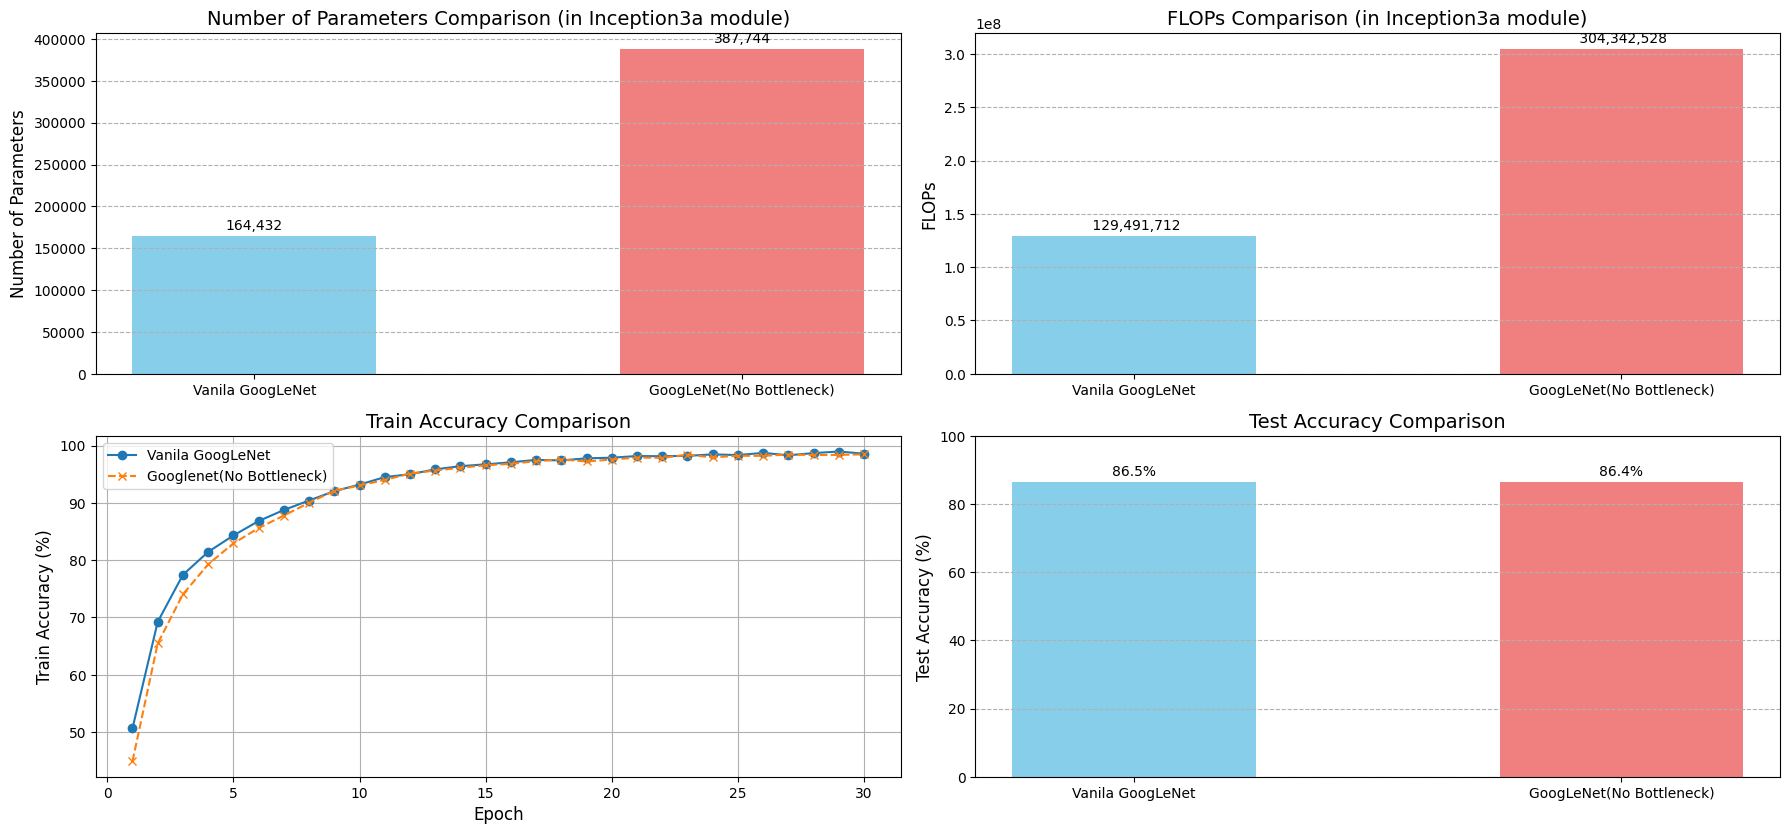

In [22]:
# 플롯 생성
epochs_range = range(1, EPOCH + 1)
model_labels = ['Vanila GoogLeNet', 'GoogLeNet(No Bottleneck)']

plt.figure(figsize=(18, 12)) # 4개의 플롯을 위한 크기 조정

# 1. 파라미터 수 비교
plt.subplot(3, 2, 1)
params_values = [total_params_googlenet, total_params_googlenet_custom]
bars_params = plt.bar(model_labels, params_values, color=['skyblue', 'lightcoral'], width=0.5)
plt.title('Number of Parameters Comparison (in Inception3a module)', fontsize=14)
plt.ylabel('Number of Parameters', fontsize=12)
plt.xticks(rotation=0, ha='center') # 레이블이 잘 보이도록 설정
# 막대 위에 값 표시
for bar in bars_params:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + max(params_values)*0.01, f'{int(yval):,}', ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--')

# 2. FLOPs 비교
plt.subplot(3, 2, 2)
flops_values = [flops_googlenet, flops_googlenet_custom]
bars_time = plt.bar(model_labels, flops_values, color=['skyblue', 'lightcoral'], width=0.5)
plt.title('FLOPs Comparison (in Inception3a module)', fontsize=14)
plt.ylabel('FLOPs', fontsize=12)
plt.xticks(rotation=0, ha='center') # 레이블이 잘 보이도록 설정
# 막대 위에 값 표시
for bar in bars_time:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + max(flops_values)*0.01, f'{yval: ,}', ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--')

# 3. 에폭별 학습 정확도 비교
plt.subplot(3, 2, 3)
plt.plot(epochs_range, acc_history_googlenet, marker='o', linestyle='-', label='Vanila GoogLeNet')
plt.plot(epochs_range, acc_history_googlenet_custom, marker='x', linestyle='--', label='Googlenet(No Bottleneck)')
plt.title('Train Accuracy Comparison', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Train Accuracy (%)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# 4. 최종 테스트 정확도 비교
plt.subplot(3, 2, 4)
test_accuracies_values = [test_accuracy_googlenet, test_accuracy_googlenet_custom]
bars_test_acc = plt.bar(model_labels, test_accuracies_values, color=['skyblue', 'lightcoral'], width=0.5)
plt.title('Test Accuracy Comparison', fontsize=14)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.ylim(0, 100) # Y축 범위: 0에서 100 (정확도)
plt.xticks(rotation=0, ha='center') # 레이블이 잘 보이도록 설정
# 막대 위에 값 표시
for bar in bars_test_acc:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1.0, f'{yval:.1f}%', ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--')

# 플롯들이 겹치지 않도록 레이아웃 조정
plt.tight_layout()
plt.show()

**실험 4:** 깊게 쌓은 Network의 문제점 - 아주 깊게 쌓은 Network의 Gradient와 성능은 어떻게 나타날까? (in VGG, GoogLeNet)

In [63]:
class VGG16(nn.Module): # Vanila VGG16
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 224 -> 112

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 112 -> 56

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 56 -> 28

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 28 -> 14

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 14 -> 7
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), # Block 5의 마지막 Conv2d 출력 채널은 512
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [64]:
class VGG50(nn.Module): # VGG50 - 47 conv layers + 3 fc layers
    def __init__(self, num_classes=10):
        super(VGG50, self).__init__()

        # Block 1 - 9 conv layers
        block1_layers = []
        block1_layers.append(nn.Conv2d(3, 64, kernel_size=3, padding=1))
        block1_layers.append(nn.BatchNorm2d(64))
        block1_layers.append(nn.ReLU(inplace=True))
        for i in range(8):
            block1_layers.append(nn.Conv2d(64, 64, kernel_size=3, padding=1))
            block1_layers.append(nn.BatchNorm2d(64))
            block1_layers.append(nn.ReLU(inplace=True))

        # Block 2 - 9 conv layers
        block2_layers = []
        block2_layers.append(nn.Conv2d(64, 128, kernel_size=3, padding=1))
        block2_layers.append(nn.BatchNorm2d(128))
        block2_layers.append(nn.ReLU(inplace=True))
        for i in range(8):
            block2_layers.append(nn.Conv2d(128, 128, kernel_size=3, padding=1))
            block2_layers.append(nn.BatchNorm2d(128))
            block2_layers.append(nn.ReLU(inplace=True))

        # Block 3 - 9 conv layers
        block3_layers = []
        block3_layers.append(nn.Conv2d(128, 256, kernel_size=3, padding=1))
        block3_layers.append(nn.BatchNorm2d(256))
        block3_layers.append(nn.ReLU(inplace=True))
        for i in range(8):
            block3_layers.append(nn.Conv2d(256, 256, kernel_size=3, padding=1))
            block3_layers.append(nn.BatchNorm2d(256))
            block3_layers.append(nn.ReLU(inplace=True))

        # Block 4 - 10 conv layers
        block4_layers = []
        block4_layers.append(nn.Conv2d(256, 512, kernel_size=3, padding=1))
        block4_layers.append(nn.BatchNorm2d(512))
        block4_layers.append(nn.ReLU(inplace=True))
        for i in range(9):
            block4_layers.append(nn.Conv2d(512, 512, kernel_size=3, padding=1))
            block4_layers.append(nn.BatchNorm2d(512))
            block4_layers.append(nn.ReLU(inplace=True))

        # Block 5 - 10 conv layers
        block5_layers = []
        for i in range(10):
            block5_layers.append(nn.Conv2d(512, 512, kernel_size=3, padding=1))
            block5_layers.append(nn.BatchNorm2d(512))
            block5_layers.append(nn.ReLU(inplace=True))

        self.features = nn.Sequential(
            *block1_layers,
            nn.MaxPool2d(kernel_size=2, stride=2), # 224 -> 112
            *block2_layers,
            nn.MaxPool2d(kernel_size=2, stride=2), # 112 -> 56
            *block3_layers,
            nn.MaxPool2d(kernel_size=2, stride=2), # 56 -> 28
            *block4_layers,
            nn.MaxPool2d(kernel_size=2, stride=2), # 28 -> 14
            *block5_layers,
            nn.MaxPool2d(kernel_size=2, stride=2)  # 14 -> 7
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), # Block 5의 마지막 Conv2d 출력 채널은 512
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [65]:
from typing import Optional, Tuple, Union, Any, List

class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.BatchNorm2d(ch1x1),
            nn.ReLU(inplace=True)
        )

        # 1x1 conv -> 3x3 conv branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.BatchNorm2d(ch3x3red),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ch3x3),
            nn.ReLU(inplace=True)
        )

        # 1x1 conv -> 5x5 conv branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.BatchNorm2d(ch5x5red),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2), # 5x5 conv, padding=2
            nn.BatchNorm2d(ch5x5),
            nn.ReLU(inplace=True)
        )

        # 3x3 maxpool -> 1x1 conv branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)


class GoogLeNet(nn.Module): # Standard GoogLeNet - 22layers (stem(3) + 9 inception module(18) + fc(1))
    def __init__(self, num_classes=10, dropout=0.2):
        super(GoogLeNet, self).__init__()

        # Stem: Conv -> Pool -> LRN -> Conv_reduce -> Conv -> LRN -> Pool
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        ) # 224x224 -> 112x112
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True) # 112x112 -> 56x56
        self.lrn1 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)

        self.conv2_reduce = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True)
        )
        self.lrn2 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True) # 56x56 -> 28x28

        # Inception modules
        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)  # out: 256
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64) # out: 480
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True) # 28x28 -> 14x14

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)   # out: 512
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)  # out: 512
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)  # out: 512
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)  # out: 528
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128) # out: 832
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128) # out: 832
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128) # out: 1024

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Global Average Pooling
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[torch.Tensor]]:
        # N x 3 x 224 x 224
        x = self.conv1(x) # -> N x 64 x 112 x 112
        x = self.maxpool1(x) # -> N x 64 x 56 x 56
        x = self.lrn1(x)
        x = self.conv2_reduce(x) # -> N x 64 x 56 x 56
        x = self.conv2(x) # -> N x 192 x 56 x 56
        x = self.lrn2(x)
        x = self.maxpool2(x) # -> N x 192 x 28 x 28

        x = self.inception3a(x) # -> N x 256 x 28 x 28
        x = self.inception3b(x) # -> N x 480 x 28 x 28
        x = self.maxpool3(x) # -> N x 480 x 14 x 14

        x = self.inception4a(x) # -> N x 512 x 14 x 14

        x = self.inception4b(x) # -> N x 512 x 14 x 14
        x = self.inception4c(x) # -> N x 512 x 14 x 14
        x = self.inception4d(x) # -> N x 528 x 14 x 14

        x = self.inception4e(x) # -> N x 832 x 14 x 14
        x = self.maxpool4(x) # -> N x 832 x 7 x 7

        x = self.inception5a(x) # -> N x 832 x 7 x 7
        x = self.inception5b(x) # -> N x 1024 x 7 x 7

        x = self.avgpool(x) # -> N x 1024 x 1 x 1
        x = torch.flatten(x, 1) # -> N x 1024
        x = self.dropout(x)
        main_output = self.fc(x) # -> N x num_classes

        return main_output

In [66]:
from typing import Optional, Tuple, Union, Any, List

class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.BatchNorm2d(ch1x1),
            nn.ReLU(inplace=True)
        )

        # 1x1 conv -> 3x3 conv branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.BatchNorm2d(ch3x3red),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ch3x3),
            nn.ReLU(inplace=True)
        )

        # 1x1 conv -> 5x5 conv branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.BatchNorm2d(ch5x5red),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2), # 5x5 conv, padding=2
            nn.BatchNorm2d(ch5x5),
            nn.ReLU(inplace=True)
        )

        # 3x3 maxpool -> 1x1 conv branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)


class GoogLeNet_50(nn.Module): # GoogLeNet_50 - 50layers (stem(3) + 23 inception module(46) + fc(1))
    def __init__(self, num_classes=10, dropout=0.2):
        super(GoogLeNet_50, self).__init__()

        # Stem: Conv -> Pool -> LRN -> Conv_reduce -> Conv -> LRN -> Pool (3 conv layers)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        ) # 224x224 -> 112x112
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True) # 112x112 -> 56x56
        self.lrn1 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)

        self.conv2_reduce = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True)
        )
        self.lrn2 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True) # 56x56 -> 28x28

        # 23 Inception modules (46 layers)
        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)  # out: 256
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64) # out: 480
        self.inception3c = Inception(480, 160, 112, 224, 24, 64, 80) # out: 528
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True) # 28x28 -> 14x14

        self.inception4a = Inception(528, 192, 96, 208, 16, 48, 112)   # Output: 560
        self.inception4b = Inception(560, 192, 128, 256, 24, 64, 128)  # Output: 640
        self.inception4c = Inception(640, 224, 144, 288, 32, 64, 128)  # Output: 704
        self.inception4d = Inception(704, 224, 160, 320, 32, 80, 128)  # Output: 752
        self.inception4e = Inception(752, 256, 160, 320, 40, 80, 160)  # Output: 816
        self.inception4f = Inception(816, 256, 192, 384, 40, 96, 160)  # Output: 896
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.inception5a = Inception(896, 256, 192, 384, 48, 128, 192) # Output: 960
        self.inception5b = Inception(960, 320, 192, 384, 48, 128, 192) # Output: 1024
        self.inception5c = Inception(1024, 320, 208, 416, 48, 128, 192)# Output: 1056
        self.inception5d = Inception(1056, 352, 208, 416, 64, 128, 224)# Output: 1120
        self.inception5e = Inception(1120, 352, 224, 448, 64, 128, 224)# Output: 1152
        self.inception5f = Inception(1152, 384, 224, 448, 64, 160, 224)# Output: 1216
        self.inception5g = Inception(1216, 384, 240, 480, 64, 160, 256)# Output: 1280
        self.inception5h = Inception(1280, 416, 240, 480, 80, 160, 256)# Output: 1312

        self.inception6a = Inception(1312, 416, 256, 512, 80, 160, 256) # Output: 1344
        self.inception6b = Inception(1344, 416, 272, 544, 80, 160, 256) # Output: 1376
        self.inception6c = Inception(1376, 448, 272, 544, 80, 160, 256) # Output: 1408
        self.inception6d = Inception(1408, 448, 288, 576, 80, 160, 256) # Output: 1440
        self.inception6e = Inception(1440, 480, 288, 576, 80, 160, 256) # Output: 1472
        self.inception6f = Inception(1472, 480, 304, 608, 96, 192, 256) # Output: 1536

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Global Average Pooling
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(1536, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Stem
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.lrn1(x)
        x = self.conv2_reduce(x)
        x = self.conv2(x)
        x = self.lrn2(x)
        x = self.maxpool2(x)

        # Inception3x
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.inception3c(x)
        x = self.maxpool3(x)

        # Inception4x
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.inception4f(x)
        x = self.maxpool4(x)

        # Inception5x
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.inception5c(x)
        x = self.inception5d(x)
        x = self.inception5e(x)
        x = self.inception5f(x)
        x = self.inception5g(x)
        x = self.inception5h(x)

        # Inception6x
        x = self.inception6a(x)
        x = self.inception6b(x)
        x = self.inception6c(x)
        x = self.inception6d(x)
        x = self.inception6e(x)
        x = self.inception6f(x)

        # Classifier
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [67]:
BATCH_SIZE = 64
LR = 1e-3
EPOCH = 10
criterion = nn.CrossEntropyLoss()

In [68]:
TARGET_IMG_SIZE = 224
CIFAR10_TRAIN_MEAN = (0.4914, 0.4822, 0.4465) # 원본 CIFAR-10 통계치
CIFAR10_TRAIN_STD = (0.2470, 0.2435, 0.2616) # 원본 CIFAR-10 통계치

# 기본 transform (업샘플링 + Tensor 변환 + 정규화)
transform_upsampled = transforms.Compose([
    transforms.Resize((TARGET_IMG_SIZE, TARGET_IMG_SIZE), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_TRAIN_MEAN, CIFAR10_TRAIN_STD)
])

# 기본 학습 데이터셋 (Augmentation 없음)
train_DS = datasets.CIFAR10(
    root = '/content/drive/MyDrive/Colab Notebooks/data',
    train=True,
    download=True,
    transform=transform_upsampled
)

# 기본 테스트 데이터셋 (Augmentation 없음)
test_DS = datasets.CIFAR10(
    root = '/content/drive/MyDrive/Colab Notebooks/data',
    train=False,
    download=True,
    transform=transform_upsampled
)


g = torch.Generator()
g.manual_seed(random_seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# 기본 학습 데이터로더 (Augmentation 미적용)
train_DL = torch.utils.data.DataLoader(
    train_DS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    generator=g,
    worker_init_fn=seed_worker,
    pin_memory=True
)

# 기본 테스트 데이터로더 (당연히 Augmentation 미적용)
test_DL = torch.utils.data.DataLoader(
    test_DS,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    generator=g,
    worker_init_fn=seed_worker,
    pin_memory=True
)

In [69]:
import torch.optim as optim

def Train(model, train_DL, criterion): # 학습 및 첫 Epoch 마지막 배치에서의 Gradient 절댓값 평균 레이어 별로 측정
    optimizer = optim.Adam(model.parameters(), lr=LR)

    loss_history = []
    acc_history = []

    # 첫 번째 epoch의 마지막 배치에서 계산된 그래디언트 절댓값 평균을 저장할 리스트.
    gradient_of_layers_from_first_epoch = []

    NoT = len(train_DL.dataset)

    model.train()

    for ep in range(EPOCH):
        rloss = 0
        rcorrect = 0

        for batch_idx, (x_batch, y_batch) in enumerate(train_DL):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            y_hat = model(x_batch)
            loss = criterion(y_hat, y_batch)

            optimizer.zero_grad()
            loss.backward() # 이 시점에서 param.grad에 그래디언트가 계산됨

            # 첫 번째 epoch(ep == 0)의 마지막 배치(batch_idx)인 경우에만 그래디언트 수집
            if ep == 0 and batch_idx == len(train_DL) - 1:
                # gradient_of_layers_from_first_epoch 리스트가 비어있을 때만 (즉, 아직 수집 안했을 때만) 실행
                if not gradient_of_layers_from_first_epoch: # 중복 수집 방지
                    for module_name, module in model.named_modules():
                        # 현재 모듈이 Conv2d 또는 Linear 레이어인지 확인
                        if isinstance(module, (nn.Conv2d, nn.Linear)):
                            # 해당 모듈의 'weight' 파라미터에 대한 그래디언트 수집
                            if hasattr(module, 'weight') and module.weight is not None:
                                if module.weight.requires_grad and module.weight.grad is not None:
                                    avg_abs_grad_weight = torch.abs(module.weight.grad).mean().item()
                                    gradient_of_layers_from_first_epoch.appen(avg_abs_grad_weight)

            optimizer.step()

            loss_b = loss.item() * x_batch.shape[0]
            rloss += loss_b

            pred = y_hat.argmax(dim=1)
            corrects_b = torch.sum(pred == y_batch).item()
            rcorrect += corrects_b

        loss_e = rloss / NoT
        accuracy_e = rcorrect / NoT * 100

        loss_history.append(loss_e)
        acc_history.append(accuracy_e)

        print(f"Epoch: {ep+1}, train loss: {round(loss_e,3)}, train accuracy: {round(accuracy_e,1)} %")

    return loss_history, acc_history, gradient_of_layers_from_first_epoch


def Test(model,test_DL):
    model.eval()
    with torch.no_grad():
        rcorrect = 0
        for x_batch, y_batch in test_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            y_hat = model(x_batch)
            pred = y_hat.argmax(dim=1)
            corrects_b = torch.sum(pred == y_batch).item()
            rcorrect += corrects_b
        accuracy_e = rcorrect/len(test_DL.dataset)*100
    print(f"Test accuracy: {rcorrect}/{len(test_DL.dataset)} ({round(accuracy_e,1)} %)")
    return round(accuracy_e,1)

In [70]:
print("="*30)
print("Vanila VGG 16 모델 학습")
print("="*30)

model_vgg16 = VGG16().to(DEVICE)
print(model_vgg16)

# 1. 학습 및 첫 Epoch 마지막 배치에서의 Gradient 절댓값 평균 레이어 별로 측정
print(f"\n\n학습 시작")
loss_history_vgg16, acc_history_vgg16, gradient_vgg16 = Train(model_vgg16, train_DL, criterion)

# 2. 테스트
print("\nVanila VGG16 테스트")
test_accuracy_vgg16 = Test(model_vgg16, test_DL)

Vanila VGG 16 모델 학습


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [30]:
print("="*30)
print("VGG 50 모델 학습")
print("="*30)

model_vgg50 = VGG50().to(DEVICE)
print(model_vgg50)

# 1. 학습 및 첫 Epoch 마지막 배치에서의 Gradient 절댓값 평균 레이어 별로 측정
print(f"\n\n학습 시작")
loss_history_vgg50, acc_history_vgg50, gradient_vgg50 = Train(model_vgg50, train_DL, criterion)

# 2. 테스트
print("\nVGG50 테스트")
test_accuracy_vgg50 = Test(model_vgg50, test_DL)

VGG 50 모델 학습
VGG50(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inpl

In [31]:
print("="*30)
print("Vanila GoogLeNet 모델 학습")
print("="*30)

model_googlenet = GoogLeNet().to(DEVICE)
print(model_googlenet)

# 1. 학습 및 첫 Epoch 마지막 배치에서의 Gradient 절댓값 평균 레이어 별로 측정
print(f"\n\n학습 시작")
loss_history_googlenet, acc_history_googlenet, gradient_googlenet = Train(model_googlenet, train_DL, criterion)

# 2. 테스트
print("\nVanila GoogLeNet 테스트")
test_accuracy_googlenet = Test(model_googlenet, test_DL)

Vanila GoogLeNet 모델 학습
GoogLeNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (lrn1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  (conv2_reduce): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (lrn2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): In

In [32]:
print("="*30)
print("GoogLeNet 50 모델 학습")
print("="*30)

model_googlenet50 = GoogLeNet_50().to(DEVICE)
print(model_googlenet50)

# 1. 학습 및 첫 Epoch 마지막 배치에서의 Gradient 절댓값 평균 레이어 별로 측정
print(f"\n\n학습 시작")
loss_history_googlenet50, acc_history_googlenet50, gradient_googlenet50 = Train(model_googlenet50, train_DL, criterion)

# 2. 테스트
print("\nGoogLeNet50 테스트")
test_accuracy_googlenet50 = Test(model_googlenet50, test_DL)

GoogLeNet 50 모델 학습
GoogLeNet_50(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (lrn1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  (conv2_reduce): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (lrn2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inc

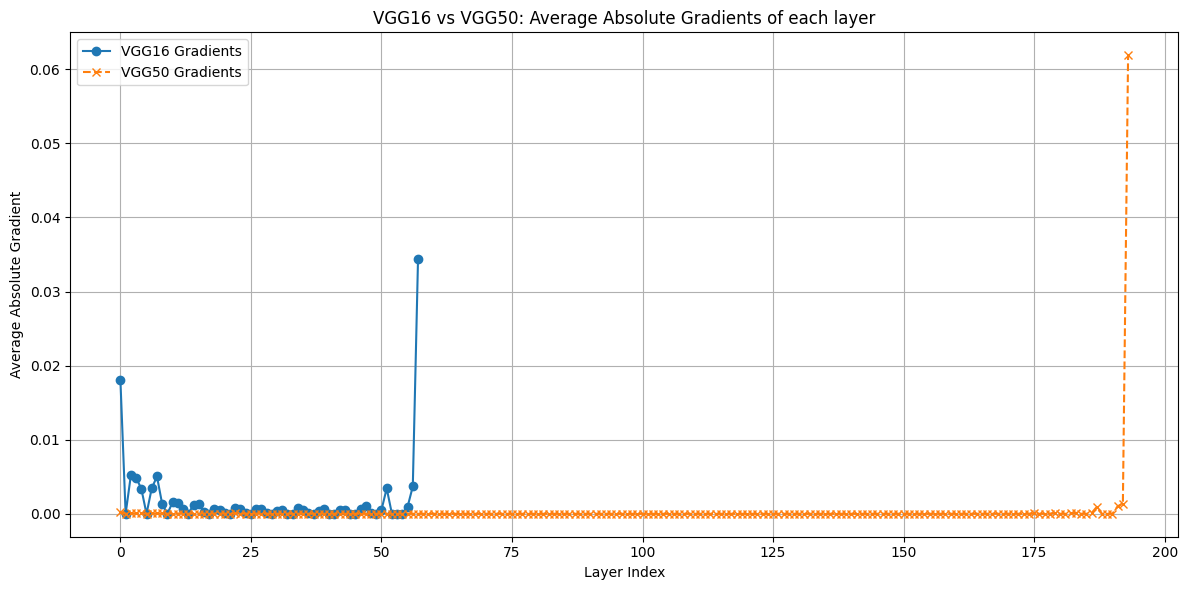

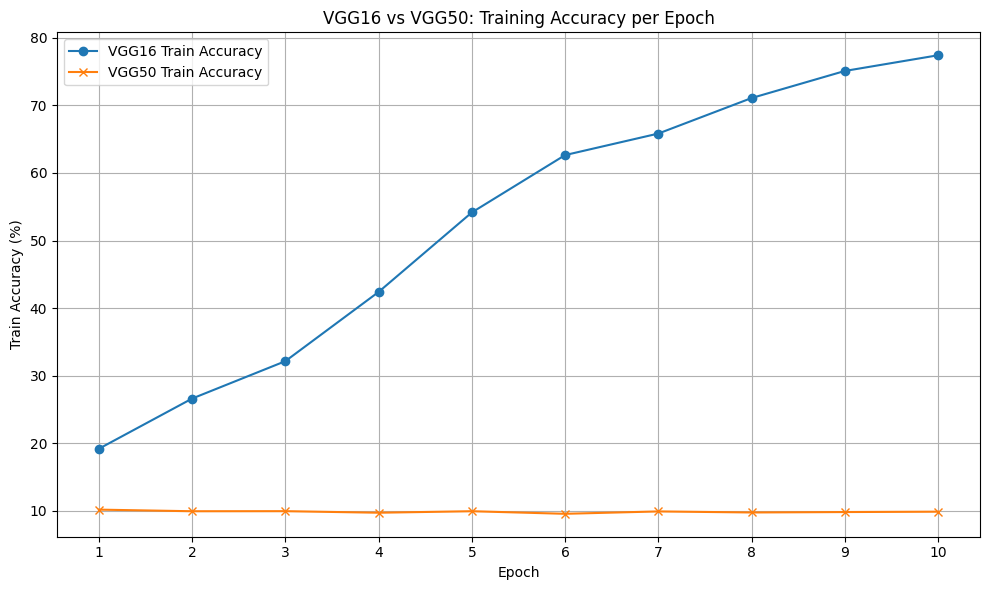

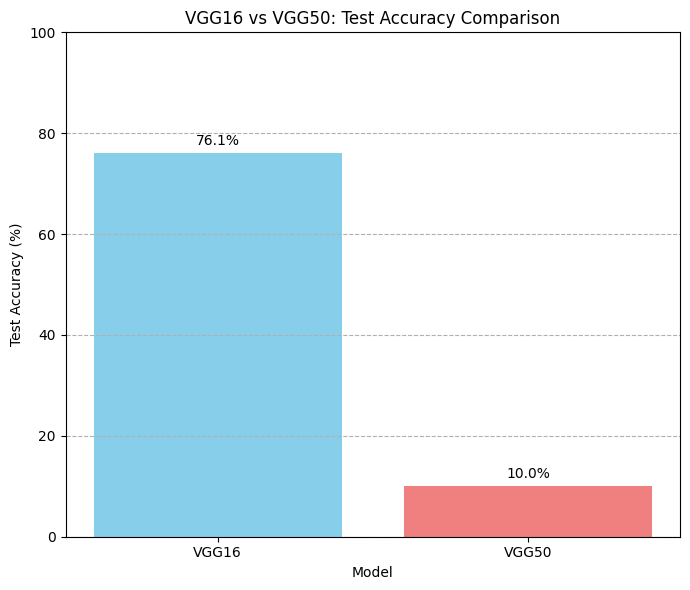

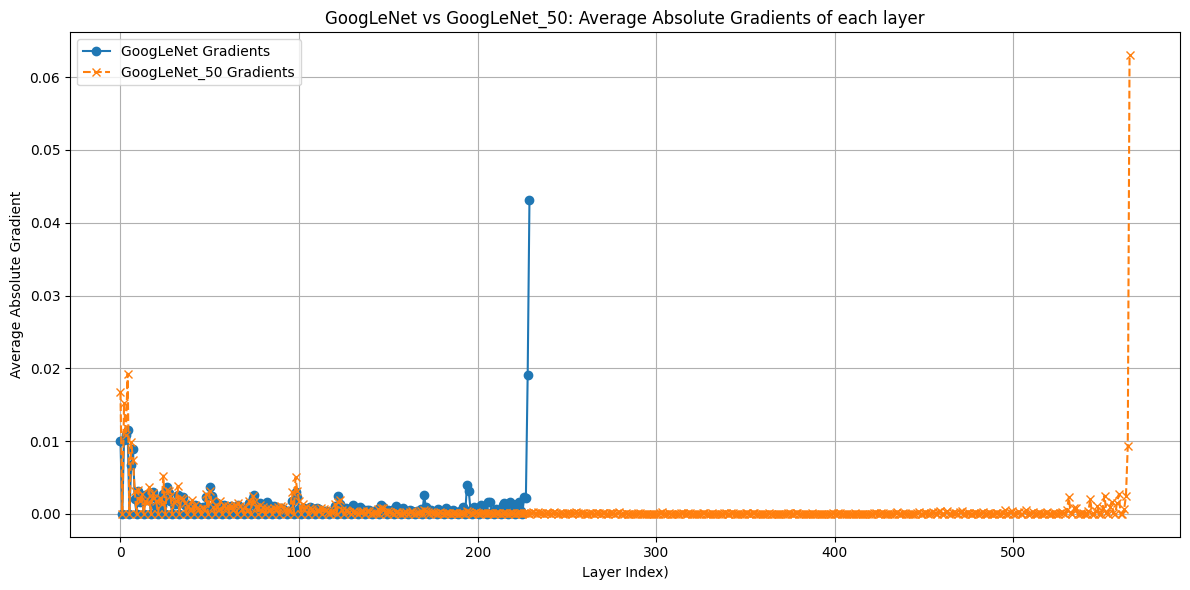

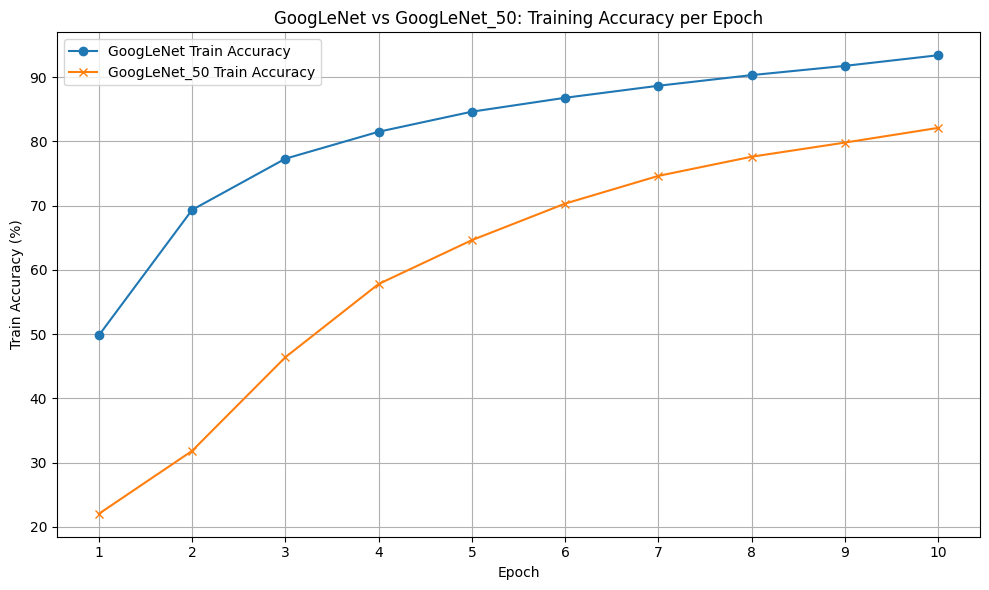

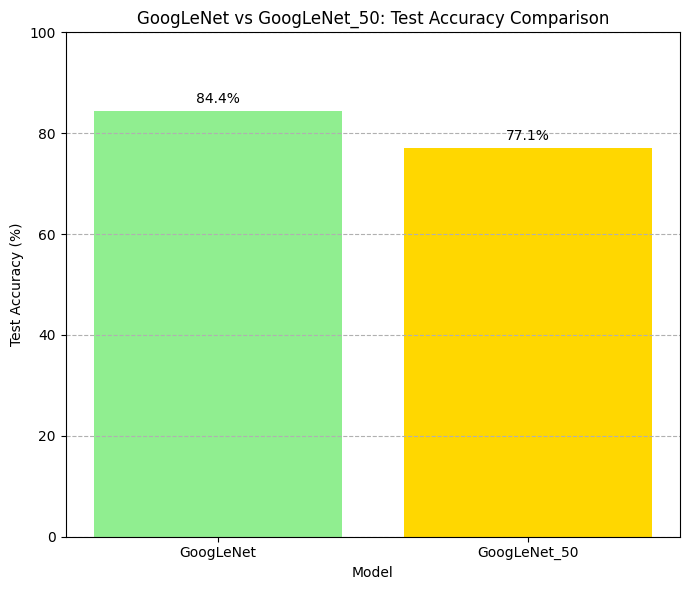

In [33]:
# 1. VGG16과 VGG50의 각 레이어 별 gradient 절댓값 평균 비교 (레이어는 forward 순서대로 나타남)
plt.figure(figsize=(12, 6))
plt.plot(gradient_vgg16, label='VGG16 Gradients', marker='o', linestyle='-')
plt.plot(gradient_vgg50, label='VGG50 Gradients', marker='x', linestyle='--')
plt.xlabel('Layer Index')
plt.ylabel('Average Absolute Gradient')
plt.title('VGG16 vs VGG50: Average Absolute Gradients of each layer')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. VGG16, VGG50의 Epoch 당 Train Accuracy 비교
epochs_vgg = range(1, len(acc_history_vgg16) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs_vgg, acc_history_vgg16, label='VGG16 Train Accuracy', marker='o')
plt.plot(epochs_vgg, acc_history_vgg50, label='VGG50 Train Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy (%)')
plt.title('VGG16 vs VGG50: Training Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.xticks(epochs_vgg) # 각 에포크 번호를 x축에 표시
plt.tight_layout()
plt.show()

# 3. VGG16, VGG50의 Test Accuracy 비교 (Bar Chart)
vgg_models = ['VGG16', 'VGG50']
vgg_test_accuracies = [test_accuracy_vgg16, test_accuracy_vgg50]
plt.figure(figsize=(7, 6))
bars_vgg = plt.bar(vgg_models, vgg_test_accuracies, color=['skyblue', 'lightcoral'])
plt.xlabel('Model')
plt.ylabel('Test Accuracy (%)')
plt.title('VGG16 vs VGG50: Test Accuracy Comparison')
plt.ylim(0, 100) # Y축 범위를 0-100%로 설정
for bar in bars_vgg:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.1f}%', ha='center', va='bottom')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# 4. GoogLeNet과 GoogLeNet_50의 각 레이어 별 gradient 절댓값 평균 비교 (레이어는 forward 순서대로 나타남)
plt.figure(figsize=(12, 6))
plt.plot(gradient_googlenet, label='GoogLeNet Gradients', marker='o', linestyle='-')
plt.plot(gradient_googlenet50, label='GoogLeNet_50 Gradients', marker='x', linestyle='--')
plt.xlabel('Layer Index)')
plt.ylabel('Average Absolute Gradient')
plt.title('GoogLeNet vs GoogLeNet_50: Average Absolute Gradients of each layer')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. GoogLeNet, GoogLeNet_50의 Epoch 당 Train Accuracy 비교
epochs_google = range(1, len(acc_history_googlenet) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs_google, acc_history_googlenet, label='GoogLeNet Train Accuracy', marker='o')
plt.plot(epochs_google, acc_history_googlenet50, label='GoogLeNet_50 Train Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy (%)')
plt.title('GoogLeNet vs GoogLeNet_50: Training Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.xticks(epochs_google) # 각 에포크 번호를 x축에 표시
plt.tight_layout()
plt.show()

# 6. GoogLeNet, GoogLeNet_50의 Test Accuracy 비교 (Bar Chart)
google_models = ['GoogLeNet', 'GoogLeNet_50']
google_test_accuracies = [test_accuracy_googlenet, test_accuracy_googlenet50]
plt.figure(figsize=(7, 6))
bars_google = plt.bar(google_models, google_test_accuracies, color=['lightgreen', 'gold'])
plt.xlabel('Model')
plt.ylabel('Test Accuracy (%)')
plt.title('GoogLeNet vs GoogLeNet_50: Test Accuracy Comparison')
plt.ylim(0, 100) # Y축 범위를 0-100%로 설정
for bar in bars_google:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.1f}%', ha='center', va='bottom')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

**실험 5:** ResNet - 아무리 깊게 쌓아도 왜 성능이 하락하지 않는가?

In [51]:
from typing import Type, List, Callable, Any

class BasicBlock(nn.Module):
    expansion = 1  # output channels multiplier

    def __init__(self, inplanes: int, planes: int, stride: int = 1,
                 downsample: nn.Module | None = None) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes: int, planes: int, stride: int = 1,
                 downsample: nn.Module | None = None) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block: Type[nn.Module], layers: List[int],
                 num_classes: int = 100) -> None:
        super().__init__()
        self.inplanes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)


    def _make_layer(self, block: Type[nn.Module], planes: int, blocks: int,
                    stride: int = 1) -> nn.Sequential:
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers: list[nn.Module] = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [52]:
def resnet18(num_classes: int = 100) -> ResNet:
    """ResNet‑18 – 2×[2,2,2,2] BasicBlocks"""
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)


def resnet50(num_classes: int = 100) -> ResNet:
    """ResNet‑50 – 3×[3,4,6,3] Bottleneck blocks"""
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)


def resnet101(num_classes: int = 100) -> ResNet:
    """ResNet‑101 – 3×[3,4,23,3] Bottleneck blocks"""
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes)

In [53]:
BATCH_SIZE = 128
LR = 1e-3
EPOCH = 50
criterion = nn.CrossEntropyLoss()

In [54]:
TARGET_IMG_SIZE = 224

CIFAR100_TRAIN_MEAN = (0.5071, 0.4865, 0.4409) # CIFAR-100 통계치로 변경
CIFAR100_TRAIN_STD  = (0.2673, 0.2564, 0.2762) # CIFAR-100 통계치로 변경

# 기본 transform (업샘플링 + Tensor 변환 + 정규화)
transform_upsampled = transforms.Compose([
    transforms.Resize((TARGET_IMG_SIZE, TARGET_IMG_SIZE), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_TRAIN_MEAN, CIFAR100_TRAIN_STD)
])

# 기본 학습 데이터셋
train_DS = datasets.CIFAR100(
    root = '/content/drive/MyDrive/Colab Notebooks/data',
    train=True,
    download=True,
    transform=transform_upsampled
)

# 기본 테스트 데이터셋
test_DS = datasets.CIFAR100(
    root = '/content/drive/MyDrive/Colab Notebooks/data',
    train=False,
    download=True,
    transform=transform_upsampled
)

g = torch.Generator()
g.manual_seed(random_seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# 기본 학습 데이터로더 (Augmentation 미적용)
train_DL = torch.utils.data.DataLoader(
    train_DS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    generator=g,
    worker_init_fn=seed_worker,
    pin_memory=True
)

# 기본 테스트 데이터로더 (당연히 Augmentation 미적용)
test_DL = torch.utils.data.DataLoader(
    test_DS,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    generator=g,
    worker_init_fn=seed_worker,
    pin_memory=True
)

In [55]:
def Train(model, train_DL, criterion):
    optimizer = optim.Adam(model.parameters(), lr=LR)

    loss_history=[]
    acc_history=[]

    NoT = len(train_DL.dataset)

    model.train()

    for ep in range(EPOCH):
        rloss = 0
        rcorrect = 0

        for x_batch, y_batch in train_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            y_hat = model(x_batch)
            loss = criterion(y_hat, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_b = loss.item() * x_batch.shape[0]
            rloss += loss_b
            pred = y_hat.argmax(dim=1)
            corrects_b = torch.sum(pred == y_batch).item()
            rcorrect += corrects_b

        loss_e = rloss/NoT
        accuracy_e = rcorrect/NoT * 100
        loss_history += [loss_e]
        acc_history += [accuracy_e]
        print(f"Epoch: {ep+1}, train loss: {round(loss_e,3)}, train accuracy: {round(accuracy_e,1)} %")
        print("-"*20)

    return loss_history, acc_history


def Test(model,test_DL):
    model.eval()
    with torch.no_grad():
        rcorrect = 0
        for x_batch, y_batch in test_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            y_hat = model(x_batch)
            pred = y_hat.argmax(dim=1)
            corrects_b = torch.sum(pred == y_batch).item()
            rcorrect += corrects_b
        accuracy_e = rcorrect/len(test_DL.dataset)*100
    print(f"Test accuracy: {rcorrect}/{len(test_DL.dataset)} ({round(accuracy_e,1)} %)")
    return round(accuracy_e,1)

In [56]:
model_resnet18 = resnet18().to(DEVICE)
print(model_resnet18)

print("="*30)
print("ResNet 18 학습")
print("="*30)
loss_history_resnet18, acc_history_resnet18 = Train(model_resnet18, train_DL, criterion)

print("\nResNet 18 테스트")
test_acc_resnet18 = Test(model_resnet18, test_DL)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [48]:
model_resnet50 = resnet50().to(DEVICE)
print(model_resnet50)

print("="*30)
print("ResNet 50 학습")
print("="*30)
loss_history_resnet50, acc_history_resnet50 = Train(model_resnet50, train_DL, criterion)

print("\nResNet 50 테스트")
test_acc_resnet50 = Test(model_resnet50, test_DL)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
model_resnet101 = resnet101().to(DEVICE)
print(model_resnet101)

print("="*30)
print("ResNet 101 학습")
print("="*30)
loss_history_resnet101, acc_history_resnet101 = Train(model_resnet101, train_DL, criterion)

print("\nResNet 101 테스트")
test_acc_resnet101 = Test(model_resnet101, test_DL)

In [ ]:
# 1. Epoch 당 Train Accuracy 비교
plt.figure(figsize=(12, 6))
epochs_range = range(1, EPOCH + 1)

plt.plot(epochs_range, acc_history_resnet18, marker='o', linestyle='-', label='ResNet-18 Train Accuracy')
plt.plot(epochs_range, acc_history_resnet50, marker='s', linestyle='--', label='ResNet-50 Train Accuracy')
plt.plot(epochs_range, acc_history_resnet101, marker='^', linestyle='-.', label='ResNet-101 Train Accuracy')

plt.title('ResNet Model Training Accuracy Comparison (per Epoch)', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Training Accuracy (%)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(np.arange(0, EPOCH + 1, 5 if EPOCH >=20 else 1)) # Epoch 틱 간격 조정
plt.tight_layout()
plt.show()

# 2. Test Accuracy 비교 (Bar Chart)
model_names = ['ResNet-18', 'ResNet-50', 'ResNet-101']
test_accuracies = [test_acc_resnet18, test_acc_resnet50, test_acc_resnet101]

plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, test_accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])

# 각 막대 위에 정확도 값 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval:.1f}%', ha='center', va='bottom', fontsize=12)

plt.title('ResNet Model Test Accuracy Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Test Accuracy (%)', fontsize=14)
plt.ylim(0, max(test_accuracies) + 10 if test_accuracies else 100) # Y축 범위 자동 조정
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()